In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
u_t - y*v = - phi_x - eps*u
u_t + y*u = - phi_y - eps*v
phi_t + u_x + v_y = - Q - eps*phi

Assume variables' structure can seperate into x and y directions, and
in x directions, using complex Fourier series, for example
Let zonal wavenumber k
u = f(x)*g(y) = sum^{k=N/2}_{k=-N/2}(c_k*e^(ikx)) * g(y)

then following Gill (1980), rewrite eqs
u_t - (1/2)*y*v = - phi_x - eps*u
u_t + (1/2)*y*u = - phi_y - eps*v
phi_t + u_x + v_y = - Q - eps*phi


combine above eqs, seperate variables, and given wavenumber k 
v_yy + ((-0.25*y**2) + (i*k/(2*eps)) + (-eps**2) + (-k**2))*v = - Q_y + (i*k/(2*eps))*Q
(eps**2 + k**2)*u = (1/2)*eps*y*v + i*k*v_y + i*k*Q
by specify forcing term Q, the wind field can be derived
"""


"\nu_t - y*v = - phi_x - eps*u\nu_t + y*u = - phi_y - eps*v\nphi_t + u_x + v_y = - Q - eps*phi\n\nAssume variables' structure can seperate into x and y directions, and\nin x directions, using complex Fourier series, for example\nLet zonal wavenumber k\nu = f(x)*g(y) = sum^{k=N/2}_{k=-N/2}(c_k*e^(ikx)) * g(y)\n\nthen following Gill (1980), rewrite eqs\nu_t - (1/2)*y*v = - phi_x - eps*u\nu_t + (1/2)*y*u = - phi_y - eps*v\nphi_t + u_x + v_y = - Q - eps*phi\n\n\ncombine above eqs, seperate variables, and given wavenumber k \nv_yy + ((-0.25*y**2) + (i*k/(2*eps)) + (-eps**2) + (-k**2))*v = - Q_y + (i*k/(2*eps))*Q\n(eps**2 + k**2)*u = (1/2)*eps*y*v + i*k*v_y + i*k*Q\nby specify forcing term Q, the wind field can be derived\n"

In [3]:
np.random.seed(90625)
N = 256
L = 32

print(f"Grid points : {N}")
print(f"Grid range : {L}")
x = np.linspace(-L/2,L/2,N)
y = np.linspace(-L/2,L/2,N)
xx, yy = np.meshgrid(x,y)

dx = np.abs(x[1] - x[0])
dy = np.abs(y[1] - y[0])

eps = 1e-1

Grid points : 256
Grid range : 32


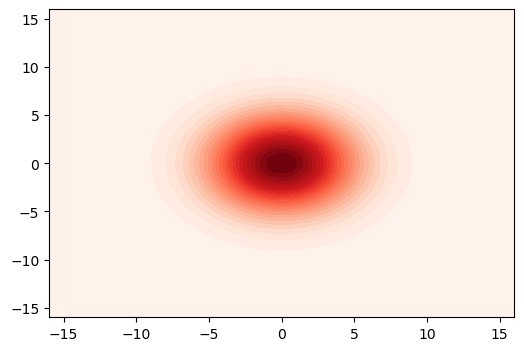

In [4]:
Q_amp = 1
Q_rad = 5
Q_centre = [0, 0]
Q = Q_amp * np.exp(-((Q_centre[0] - xx)/Q_rad)**2) * np.exp(-((Q_centre[1] - yy)/Q_rad)**2)
plt.figure(figsize = (6,4), dpi = 100)
plt.contourf(xx,yy,Q, levels = 32, cmap = "Reds")

In [5]:
diff_matrix_1st = (- np.roll(np.eye(N), 1, axis = 0) + np.roll(np.eye(N), -1, axis = 0))/2
diff_matrix_1st[0, :] = 0
diff_matrix_1st[0, 0] = -1
diff_matrix_1st[0, 1] = 1
diff_matrix_1st[-1, :] = 0
diff_matrix_1st[-1, -2] = -1
diff_matrix_1st[-1, -1] = 1
diff_matrix_1st /= dy

diff_matrix_2nd = diff_matrix_1st@diff_matrix_1st

In [6]:
k = np.fft.fftfreq(N, d = (L/(2*np.pi))/N)
#k = np.zeros_like(k)

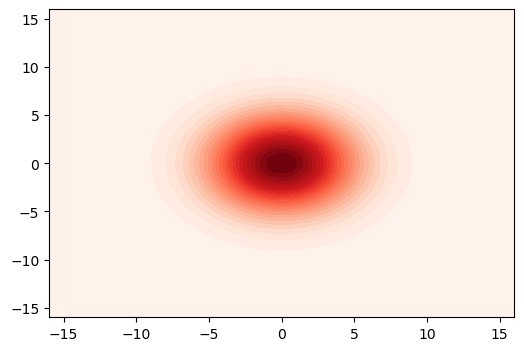

In [7]:
Q_sp = np.zeros_like(Q, dtype = np.complex128)
Q_ret = np.zeros_like(Q, dtype = np.complex128)
for i in range(np.shape(Q)[0]):
    Q_sp[i,:] = np.fft.fft(Q[i,:])
for i in range(np.shape(Q_sp)[0]):
    Q_ret[i,:] = np.fft.ifft(Q_sp[i,:])
plt.figure(figsize = (6,4), dpi = 100)
plt.contourf(xx,yy,np.real(Q_ret), levels = 32, cmap = "Reds")
#plt.savefig("TEST.png")

In [8]:
U_sp = np.zeros_like(Q_sp, dtype = np.complex128)
V_sp = np.zeros_like(Q_sp, dtype = np.complex128)

U = np.zeros_like(Q, dtype = np.complex128)
V = np.zeros_like(Q, dtype = np.complex128)

for col in range(N):
    A = diff_matrix_2nd + ((-0.25*np.diag(y**2)) + (np.eye(N)*1j*k[col]/(2*eps)) + (np.eye(N)*-eps**2) + (np.eye(N)*-k[col]**2))
    B = (-diff_matrix_1st + np.diag(y)*1j*k[col]/(2*eps))@Q_sp[:,col]
    V_sp[:,col] = np.linalg.inv(A)@B
for col in range(N):
    A = 0.5*eps*np.diag(y)
    B = 1j*k[col]*diff_matrix_1st
    C = 1j*k[col]*np.eye(N)
    D = (k[col]**2+eps**2)*np.eye(N)
    U_sp[:,col] = np.linalg.inv(D)@(A@(V_sp[:,col]) + B@(V_sp[:,col]) + C@(Q_sp[:,col]))
for i in range(N):
    U[i,:] = np.fft.ifft(U_sp[i,:])
    V[i,:] = np.fft.ifft(V_sp[i,:])

Text(0, 0.5, 'y coordinate')

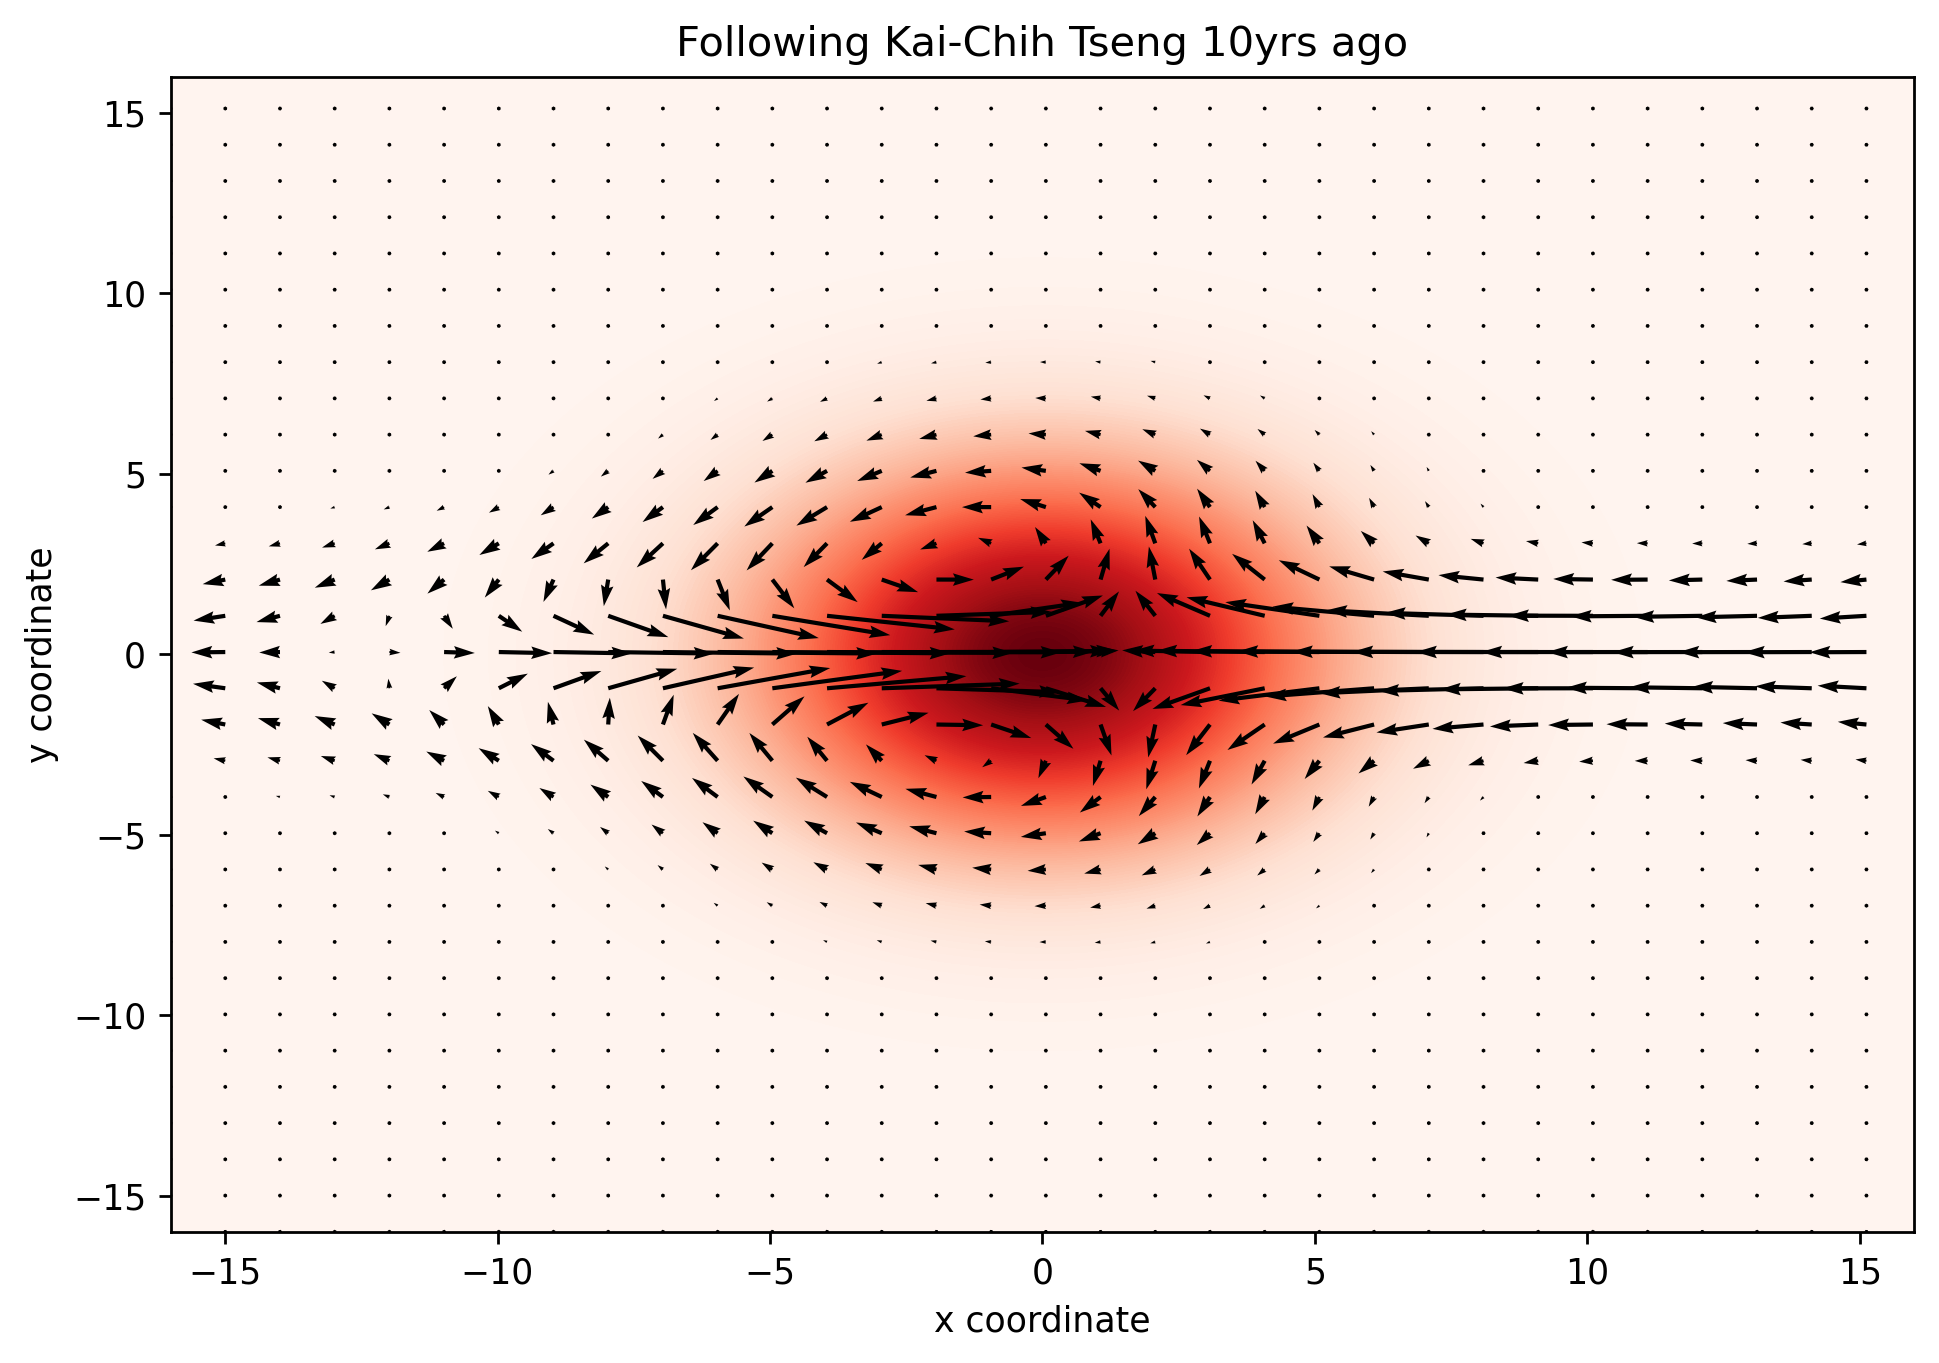

In [9]:
plt.figure(figsize = (9,6), dpi = 250)
plt.contourf(xx,yy,Q, levels = 128, cmap = "Reds")
plt.quiver(xx[::8,::8],yy[::8,::8],np.real(U)[::8,::8],np.real(V)[::8,::8],scale = 35)
plt.title("Following Kai-Chih Tseng 10yrs ago")
plt.xlabel("x coordinate")
plt.ylabel("y coordinate")
#plt.savefig("Gill response.png")